In [83]:
import datetime
import importlib
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import yfinance as yf
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import misc
importlib.reload(misc)

<module 'misc' from '/Users/K/works/git/jm-xgb/misc.py'>

In [84]:
start_date = "2013-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [85]:
ticker = [
    "XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"
] 
df: pd.Series = yf.download(ticker, start=start_date, end=end_date)["Close"]
rets = np.log(df).diff().dropna()

[*********************100%***********************]  9 of 9 completed


In [86]:
def run(rets, start_idx, n_regimes, jump_penalty, freq):
    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=jump_penalty)
    clf = XGBClassifier()

    last_fit_date = None
    def should_fit(last_fit_date, current_date, freq):
        current = current_date.date()
        if last_fit_date is None:
            return True
        delta = current - last_fit_date
        return delta.days >= freq
    
    n = rets.shape[0]
    current_idx = start_idx
    end_idx = n - 1
    w = np.ones(n)
    while True:
        current_idx += 1
        obs = rets[:current_idx]
        X = misc.feature_engineer(obs)
        if should_fit(last_fit_date, obs.index[-1], freq):
            last_fit_date = obs.index[-1].date()
            X_processed = scaler.fit_transform(clipper.fit_transform(X))
            model.fit(X_processed)
            labels = misc.rearange_labels(model.labels, obs)
            y = pd.Series(labels).shift(-1)
            y_idx = y.dropna().index
            clf.fit(
                pd.DataFrame(X_processed, columns=X.columns).loc[y_idx], 
                y.loc[y_idx].astype(int)
            )
        else:
            X_processed = scaler.transform(clipper.transform(X))
            pred_labels, pred_probs = model.prediction(X_processed)
            labels = misc.rearange_labels(pred_labels, obs)

        w[current_idx] = clf.predict(pd.DataFrame(X_processed, columns=X.columns))[-1]
        if current_idx == end_idx:
            break

    return w

In [87]:
def plot(rets, w, lambda_path):
    days = rets.index
    fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
    colors = ["white", "#4597A0", "blue", "orange"]
    ax.plot(np.array(days), np.array((1 + rets).cumprod()), color="black")
    ax.plot(np.array(days), np.array((1 + w * rets).cumprod()), color="#4597A0")
    ax2 = ax.twinx()
    ax2.plot(np.array(days), lambda_path, color="blue", alpha=0.5)
    ax.grid()
    plt.show()

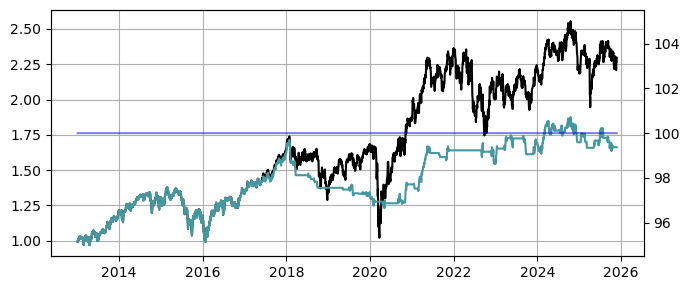

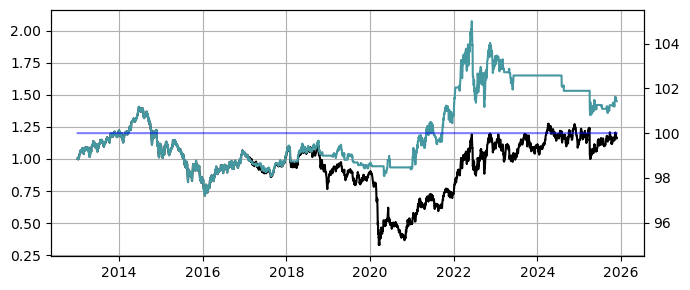

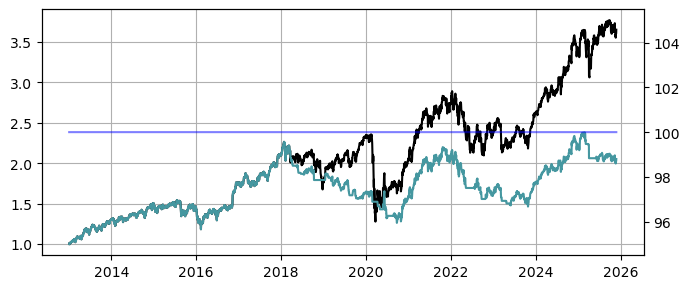

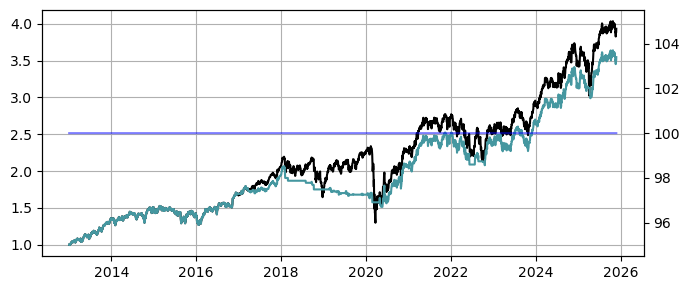

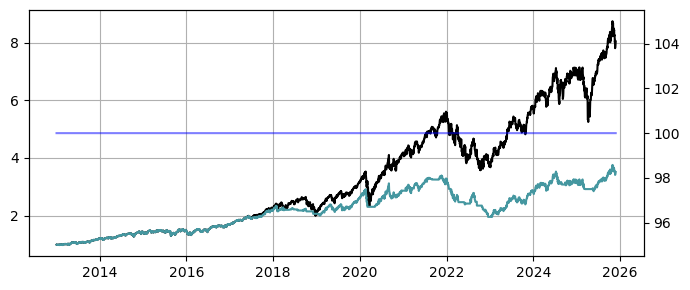

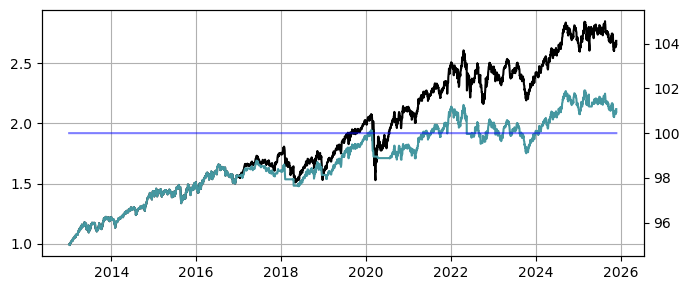

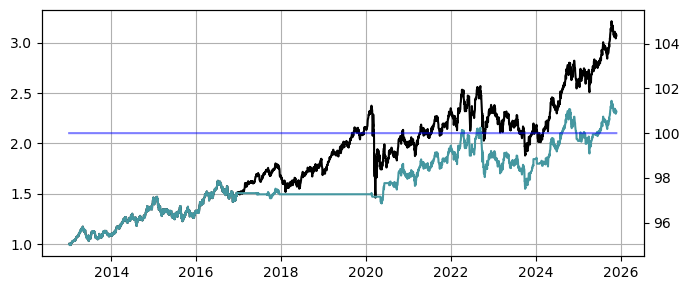

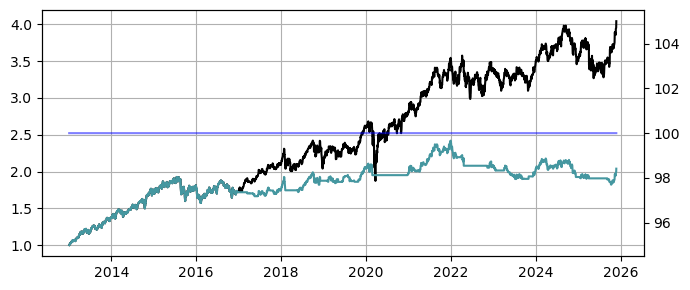

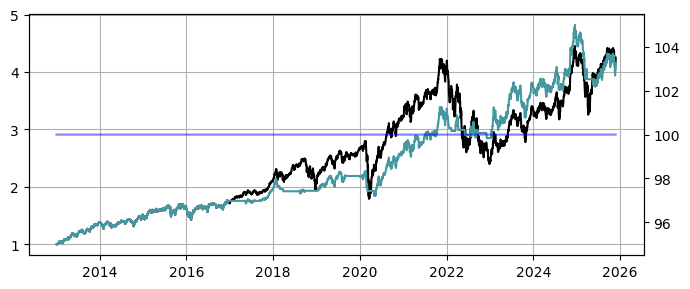

In [92]:
assets = rets.columns
asset = assets[0]

start_idx = 1000
n_regimes = 2
jump_penalty = 100
freq = 7 * 4

for asset in assets:
    w = run(rets[asset], start_idx, n_regimes, jump_penalty, freq)
    plot(rets[asset], w, np.ones_like(w)*jump_penalty)

In [89]:
def select_jump_penalty_on_window(
    rets_window: pd.Series,
    n_regimes: int,
    lambda_grid,
    train_ratio: float = 0.7,
):
    """
    rets_window: ある資産の日次リターン（Series, index は DatetimeIndex）
    lambda_grid: 候補の jump_penalty の配列（例: [0.0, 0.1, 0.3, 1, 3, 10, 30, 100]）
    """
    n = len(rets_window)
    if n < 100:  # データが短すぎる場合は適当に最初の λ を返す
        return lambda_grid[0]

    # 1) 特徴量を作る（あなたの feature_engineer をそのまま利用）
    X = misc.feature_engineer(rets_window)

    # クリッピング・スケーリングは JumpModel / XGB と同じ前処理に合わせる
    clipper = misc.Clipper(mul=3)
    scaler = misc.Scaler()
    X_clipped = clipper.fit_transform(X)
    X_scaled = scaler.fit_transform(X_clipped)   # np.ndarray になる想定

    # 2) train / validation に分割
    split_idx = int(n * train_ratio)
    # train 部分
    X_train = X_scaled[:split_idx]
    rets_train = rets_window.iloc[:split_idx]

    # validation 部分 (翌日のリターンを使うので -1 まで)
    X_val_all = X_scaled[split_idx-1:-1]      # 特徴量の位置 i から i+1 のリターンを予測
    rets_val_all = rets_window.iloc[split_idx:]  # i+1 のリターン

    if len(rets_val_all) < 10:
        return lambda_grid[0]

    best_lambda = None
    best_sharpe = -np.inf

    for lam in lambda_grid:
        # 3) train 部分で JumpModel をフィット
        jm = misc.JumpModel(n_regimes=n_regimes, jump_penalty=lam)
        jm.fit(X_train)

        # ラベルをリターンで並び替え（bullish=1, bearish=0 のように）
        labels_train = misc.rearange_labels(jm.labels, rets_train.values)

        # 1 日先ラベルを教師データにする
        # y[t] = s_{t+1}、特徴量は x_t
        y = labels_train[1:split_idx]          # 長さ split_idx-1
        X_clf = X_scaled[:split_idx-1]

        # 安全チェック
        if len(np.unique(y)) < 2:
            # 片方のクラスしかないときはこの λ はパス（Sharpe はかなり悪いものとして扱う）
            continue

        clf = XGBClassifier()
        clf.fit(X_clf, y.astype(int))

        # 4) validation 部分で 0/1 戦略のリターンをシミュレーション
        daily_returns = []
        # val 部分に対応するインデックス（X_val_all, rets_val_all はずらしてある）
        for i in range(len(X_val_all)):
            # 時点 i+split_idx-1 の特徴量から、翌日 (i+split_idx) の regime を予測するイメージ
            x_i = X_val_all[i].reshape(1, -1)
            pred_regime_next = clf.predict(x_i)[0]

            # bullish label は 1 として設計しているので 1 なら risky 資産に 100%、
            # それ以外は rf=0% とする簡易 0/1 戦略
            r_next = float(rets_val_all.iloc[i])
            if pred_regime_next == 1:
                daily_returns.append(r_next)
            else:
                daily_returns.append(0.0)

        daily_returns = np.array(daily_returns)
        if daily_returns.std(ddof=1) == 0:
            sharpe = -np.inf
        else:
            sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std(ddof=1)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_lambda = lam

    # すべての λ で Sharpe が NaN / -inf になった場合の fallback
    if best_lambda is None:
        best_lambda = lambda_grid[0]

    return best_lambda


In [90]:
def run_with_online_lambda(
    rets: pd.Series,
    start_idx: int,
    n_regimes: int,
    init_jump_penalty: float,
    fit_freq_days: int,
    lambda_grid=None,
    cv_window_days: int = 252 * 5,   # 5 年分くらい
    cv_freq_days: int = 21 * 3,      # 3 ヶ月ごとに λ 見直し
):
    """
    rets: ある資産の日次リターン（Series）
    fit_freq_days: JumpModel / XGB の再学習頻度（日数ベース）
    """
    if lambda_grid is None:
        lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)

    current_lambda = init_jump_penalty
    model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
    clf = XGBClassifier()

    last_fit_date = None
    last_cv_date = None

    def should_fit(last_date, current_date, freq_days):
        current = current_date.date()
        if last_date is None:
            return True
        delta = current - last_date
        return delta.days >= freq_days

    n = rets.shape[0]
    current_idx = start_idx
    end_idx = n - 1

    w = np.ones(n)              # regime 予測 or 重みの placeholder
    lambda_path = np.full(n, init_jump_penalty)  # 各時点で使われた λ を記録しておくと後で可視化などに便利

    while True:
        current_idx += 1
        obs = rets.iloc[:current_idx]      # ここまでの履歴
        current_date = obs.index[-1]

        # --- ここで一定間隔ごとに TS-CV をかけて jump_penalty を更新 ---
        if should_fit(last_cv_date, current_date, cv_freq_days) and len(obs) >= cv_window_days:
            window = obs.iloc[-cv_window_days:]
            best_lambda = select_jump_penalty_on_window(
                window,
                n_regimes=n_regimes,
                lambda_grid=lambda_grid,
            )
            current_lambda = best_lambda
            last_cv_date = current_date.date()
            # 新しい λ で JumpModel を作り直す（パラメータはこのあと fit し直す）
            model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
            
            last_fit_date = None

        # --- モデルの再学習（JumpModel + XGB） ---
        if should_fit(last_fit_date, current_date, fit_freq_days):
            last_fit_date = current_date.date()

            X = misc.feature_engineer(obs)
            X_processed = scaler.fit_transform(clipper.fit_transform(X))

            model.fit(X_processed)
            labels = misc.rearange_labels(model.labels, obs.values)

            # s_{t+1} を教師ラベルにする
            y = pd.Series(labels).shift(-1)
            y_idx = y.dropna().index

            clf.fit(
                pd.DataFrame(X_processed, columns=X.columns).iloc[:len(y_idx)],
                y.dropna().astype(int)
            )
        else:
            # 前回の scaler / clipper / model を使って変換と regime 推定だけやる
            X = misc.feature_engineer(obs)
            X_processed = scaler.transform(clipper.transform(X))
            pred_labels, pred_probs = model.prediction(X_processed)
            labels = misc.rearange_labels(pred_labels, obs.values)

        # --- 最後のサンプルに対する regime 予測を XGB で出す ---
        X_processed = scaler.transform(clipper.transform(misc.feature_engineer(obs)))
        x_last = pd.DataFrame(X_processed, columns=misc.feature_engineer(obs).columns).iloc[[-1]]
        w[current_idx] = clf.predict(x_last)[0]   # ここでは単に regime ラベルを保存

        lambda_path[current_idx] = current_lambda

        if current_idx == end_idx:
            break

    return w, lambda_path


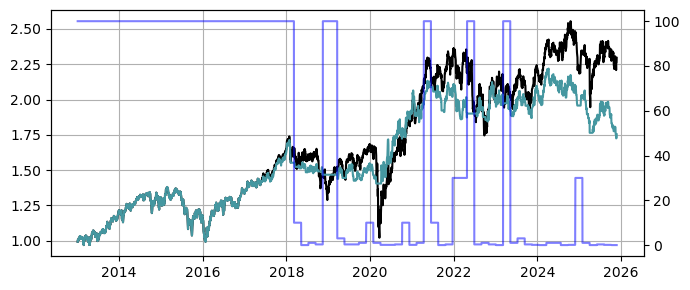

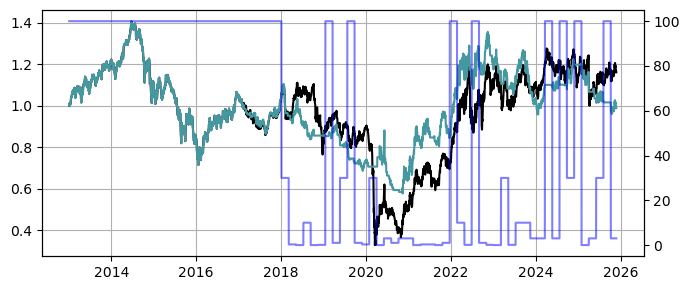

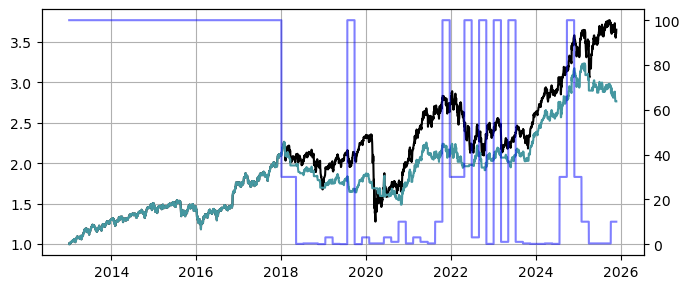

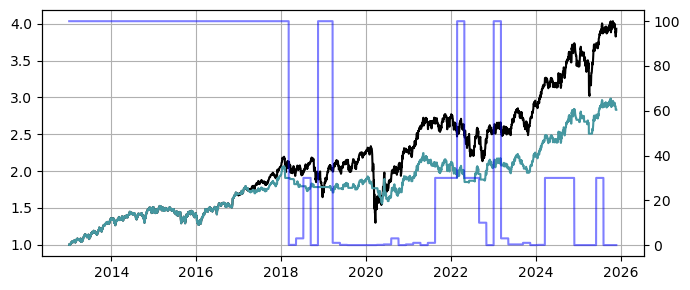

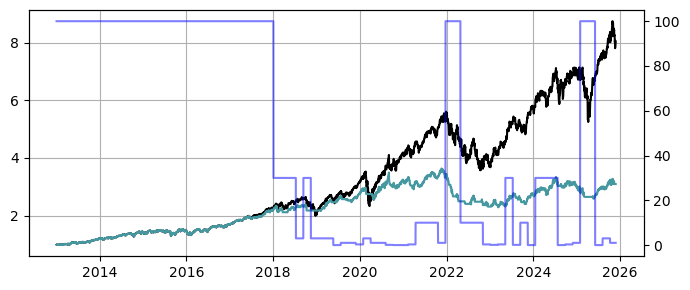

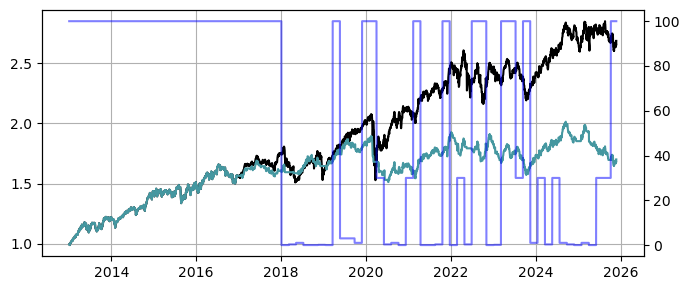

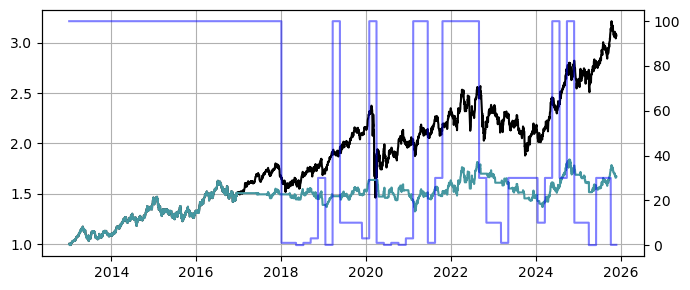

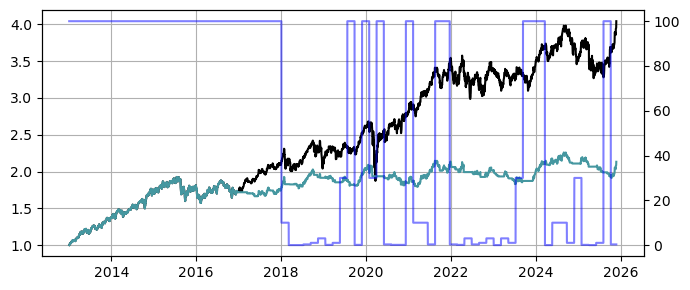

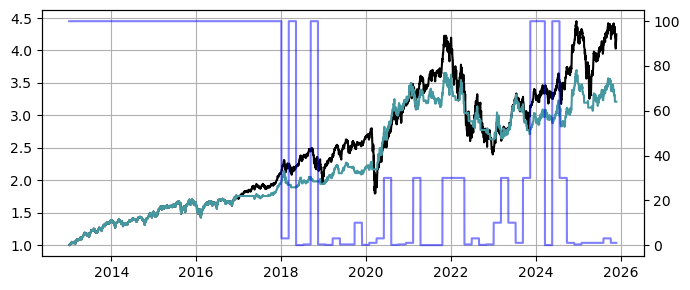

In [91]:
init_jump_penalty = 100.0      # 初期値（最初の TS-CV まではこれを使う）
fit_freq_days = 7 * 4         # もともとの freq と同じ 4 週間
lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

results = {}

for asset in assets:
    w, lambda_path = run_with_online_lambda(
        rets[asset],
        start_idx=start_idx,
        n_regimes=n_regimes,
        init_jump_penalty=init_jump_penalty,
        fit_freq_days=fit_freq_days,
        lambda_grid=lambda_grid,
        cv_window_days=252*5,
        cv_freq_days=21*3,
    )
    results[asset] = {
        "regime_pred": w,
        "lambda_path": lambda_path,
    }
    plot(rets[asset], w, lambda_path)

In [94]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import misc


def select_jump_penalty_on_window(
    rets_window: pd.Series,
    n_regimes: int,
    lambda_grid,
    train_ratio: float = 0.7,
):
    """時系列CVで、その窓の中の 0/1 戦略 Sharpe が最大の λ を選ぶ簡易版"""
    n = len(rets_window)
    if n < 100:
        return lambda_grid[0]

    X = misc.feature_engineer(rets_window)

    clipper = misc.Clipper(mul=3)
    scaler = misc.Scaler()
    X_clipped = clipper.fit_transform(X)
    X_scaled = scaler.fit_transform(X_clipped)

    split_idx = int(n * train_ratio)
    X_train = X_scaled[:split_idx]
    rets_train = rets_window.iloc[:split_idx]

    X_val_all = X_scaled[split_idx-1:-1]
    rets_val_all = rets_window.iloc[split_idx:]

    if len(rets_val_all) < 10:
        return lambda_grid[0]

    best_lambda = None
    best_sharpe = -np.inf

    for lam in lambda_grid:
        jm = misc.JumpModel(n_regimes=n_regimes, jump_penalty=lam)
        jm.fit(X_train)

        labels_train = misc.rearange_labels(jm.labels, rets_train.values)

        # s_{t+1} を教師ラベルに
        y = labels_train[1:split_idx]
        X_clf = X_scaled[:split_idx-1]

        if len(np.unique(y)) < 2:
            continue

        clf = XGBClassifier()
        clf.fit(X_clf, y.astype(int))

        daily_returns = []
        for i in range(len(X_val_all)):
            x_i = X_val_all[i].reshape(1, -1)
            pred_regime_next = clf.predict(x_i)[0]
            r_next = float(rets_val_all.iloc[i])
            if pred_regime_next == 1:      # bull のときだけ risky に投資
                daily_returns.append(r_next)
            else:
                daily_returns.append(0.0)

        daily_returns = np.array(daily_returns)
        if daily_returns.std(ddof=1) == 0:
            sharpe = -np.inf
        else:
            sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std(ddof=1)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_lambda = lam

    if best_lambda is None:
        best_lambda = lambda_grid[0]

    return best_lambda


def run_with_online_lambda_and_mu(
    rets: pd.Series,
    start_idx: int,
    n_regimes: int,
    init_jump_penalty: float,
    fit_freq_days: int,
    lambda_grid=None,
    cv_window_days: int = 252 * 5,
    cv_freq_days: int = 21 * 3,
):
    """
    単一資産のリターン rets に対して、
    - λ のオンライン更新（TS-CV）
    - JM＋XGB のオンライン学習
    - 明日のレジーム予測、レジーム別平均リターン
    をまとめて返す。
    """
    if lambda_grid is None:
        lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)

    n = len(rets)
    index = rets.index

    regime_pred = np.full(n, np.nan)
    lambda_path = np.full(n, np.nan)
    mu_bull_path = np.full(n, np.nan)
    mu_bear_path = np.full(n, np.nan)

    current_lambda = init_jump_penalty
    last_cv_date = None
    last_fit_date = None

    model = None
    clf = None
    mu_bull = 0.0
    mu_bear = 0.0

    def should_fit(last_date, current_date, freq_days):
        current = current_date.date()
        if last_date is None:
            return True
        delta = current - last_date
        return delta.days >= freq_days

    # time loop
    for t in range(start_idx, n - 1):
        obs = rets.iloc[: t + 1]
        current_date = obs.index[-1]

        # 1) λ を一定間隔ごとに TS-CV で更新
        if should_fit(last_cv_date, current_date, cv_freq_days) and len(obs) >= cv_window_days:
            window = obs.iloc[-cv_window_days:]
            best_lambda = select_jump_penalty_on_window(
                window,
                n_regimes=n_regimes,
                lambda_grid=lambda_grid,
            )
            current_lambda = best_lambda
            last_cv_date = current_date.date()

            # λ を変えたので次回は必ず再フィット
            last_fit_date = None

        # 2) 必要なら JM + XGB を再フィット
        if (last_fit_date is None) or should_fit(last_fit_date, current_date, fit_freq_days):
            last_fit_date = current_date.date()

            X = misc.feature_engineer(obs)
            X_proc = scaler.fit_transform(clipper.fit_transform(X))

            # JM を現在の λ で fit
            model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
            model.fit(X_proc)

            labels = misc.rearange_labels(model.labels, obs.values)

            # レジーム別平均リターン（bull=1, bear=0）
            if (labels == 1).any():
                mu_bull = obs.values[labels == 1].mean()
            else:
                mu_bull = 0.0
            if (labels == 0).any():
                mu_bear = obs.values[labels == 0].mean()
            else:
                mu_bear = 0.0

            # s_{t+1} を教師ラベルにする
            y = pd.Series(labels, index=obs.index).shift(-1)
            train_idx = y.dropna().index

            clf = XGBClassifier()
            clf.fit(
                pd.DataFrame(X_proc, index=obs.index).loc[train_idx],
                y.loc[train_idx].astype(int),
            )
        else:
            # モデルは既に fit 済み。特徴量だけ更新して prediction 用に使う
            X = misc.feature_engineer(obs)
            X_proc = scaler.transform(clipper.transform(X))

        # 3) 今日までの情報で「明日のレジーム」を 1 ステップ先予測
        x_last = pd.DataFrame(X_proc, index=obs.index).iloc[[-1]]
        pred_reg = clf.predict(x_last)[0]

        # 保存（t 時点で「t+1 のレジーム」を予測している想定）
        regime_pred[t] = pred_reg
        lambda_path[t] = current_lambda
        mu_bull_path[t] = mu_bull
        mu_bear_path[t] = mu_bear

    out = {
        "regime_pred": pd.Series(regime_pred, index=index),
        "lambda": pd.Series(lambda_path, index=index),
        "mu_bull": pd.Series(mu_bull_path, index=index),
        "mu_bear": pd.Series(mu_bear_path, index=index),
    }
    return out


In [96]:
from tqdm import tqdm

assets = rets.columns
start_idx = 1000
n_regimes = 2
init_jump_penalty = 100.0
fit_freq_days = 7 * 4

lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

asset_results = {}

for asset in tqdm(assets):
    res = run_with_online_lambda_and_mu(
        rets[asset],
        start_idx=start_idx,
        n_regimes=n_regimes,
        init_jump_penalty=init_jump_penalty,
        fit_freq_days=fit_freq_days,
        lambda_grid=lambda_grid,
        cv_window_days=252*5,
        cv_freq_days=21*3,
    )
    asset_results[asset] = res


100%|██████████| 9/9 [36:02<00:00, 240.29s/it]


In [97]:
asset_results

{'XLB': {'regime_pred': Date
  2013-01-03    NaN
  2013-01-04    NaN
  2013-01-07    NaN
  2013-01-08    NaN
  2013-01-09    NaN
               ... 
  2025-11-19    1.0
  2025-11-20    0.0
  2025-11-21    1.0
  2025-11-24    1.0
  2025-11-25    NaN
  Length: 3245, dtype: float64,
  'lambda': Date
  2013-01-03    NaN
  2013-01-04    NaN
  2013-01-07    NaN
  2013-01-08    NaN
  2013-01-09    NaN
               ... 
  2025-11-19    0.0
  2025-11-20    0.0
  2025-11-21    0.0
  2025-11-24    0.0
  2025-11-25    NaN
  Length: 3245, dtype: float64,
  'mu_bull': Date
  2013-01-03         NaN
  2013-01-04         NaN
  2013-01-07         NaN
  2013-01-08         NaN
  2013-01-09         NaN
                  ...   
  2025-11-19    0.002186
  2025-11-20    0.002186
  2025-11-21    0.002186
  2025-11-24    0.002186
  2025-11-25         NaN
  Length: 3245, dtype: float64,
  'mu_bear': Date
  2013-01-03         NaN
  2013-01-04         NaN
  2013-01-07         NaN
  2013-01-08         NaN
  2013-

In [99]:
import cvxpy as cp


def ewm_cov_matrix(rets_window: pd.DataFrame, halflife: int = 252):
    """
    pandas の ewm().cov() を使って、窓の最後の時点の共分散行列だけを取り出す。
    """
    # マルチインデックス (date, asset) で返ってくるので xs で最後の date を抜く
    cov_all = rets_window.ewm(halflife=halflife).cov()
    last_date = rets_window.index[-1]
    cov_last = cov_all.xs(last_date, level=0)
    return cov_last.values  # (n_assets, n_assets)


def backtest_mv_jm_xgb(
    rets_df: pd.DataFrame,
    asset_results: dict,
    start_idx: int,
    rf_daily: float = 0.0,
    gamma_risk: float = 10.0,
    gamma_trade: float = 1.0,
    w_lb: float = 0.0,
    w_ub: float = 0.40,
    max_leverage: float = 1.0,
    cov_halflife: int = 252,
    min_bullish: int = 4,
    bear_floor: float = -0.001,   # bear 予測時の μ の下限（-10bps）
):
    """
    rets_df: (T, N) 日次リターン
    asset_results: {asset: {"regime_pred", "mu_bull", "mu_bear", "lambda"}}
                   Step1 の出力をそのまま渡す想定
    start_idx: ポートフォリオ構築を開始するインデックス（学習期間の後）
    """
    dates = rets_df.index
    assets = list(rets_df.columns)
    n_assets = len(assets)
    n = len(dates)

    # 結果格納用
    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)
    lambda_hist = np.zeros((n, n_assets))

    w_prev = np.zeros(n_assets)

    for t in range(start_idx, n - 1):
        date_t = dates[t]
        next_date = dates[t + 1]

        # --- 1) 各資産の regime 予測とレジーム別 μ から μ_t ベクトルを作る ---
        mu_vec = np.zeros(n_assets)
        bullish_mask = np.zeros(n_assets, dtype=bool)

        for j, asset in enumerate(assets):
            res = asset_results[asset]
            reg = res["regime_pred"].loc[date_t]
            mu_bull = res["mu_bull"].loc[date_t]
            mu_bear = res["mu_bear"].loc[date_t]
            lam = res["lambda"].loc[date_t]

            # bull / bear で期待リターンを出し分け（論文 4.3 節）
            if reg == 1:
                mu_j = mu_bull
                bullish_mask[j] = True
            else:
                mu_j = max(mu_bear, bear_floor)

            mu_vec[j] = mu_j
            lambda_hist[t, j] = lam

        # bull 予測の資産が少ない時は「全額リスクフリー」
        if bullish_mask.sum() < min_bullish:
            w_opt = np.zeros(n_assets)
        else:
            # bearish 予測の資産は weight を 0 に縛る
            active_idx = np.where(bullish_mask)[0]

            # --- 2) 共分散 Σ_t を EWM で推定 ---
            # ここでは単純に start から t まで全期間を使う
            cov_window = rets_df.iloc[: t + 1]
            Sigma = ewm_cov_matrix(cov_window, halflife=cov_halflife)

            # cvxpy で QP を解く
            w = cp.Variable(n_assets)

            # 目的関数
            risk_term = 0.5 * gamma_risk * cp.quad_form(w, Sigma)
            ret_term = - mu_vec @ w
            trade_term = gamma_trade * cp.norm1(w - w_prev)

            obj = cp.Minimize(risk_term + ret_term + trade_term)

            constraints = []

            # ロングオンリー + 上限
            constraints += [w >= w_lb, w <= w_ub]

            # レバレッジ制約: Σ w_j ≤ max_leverage
            constraints += [cp.sum(w) <= max_leverage]

            # bearish 予測の資産は weight=0
            for j in range(n_assets):
                if not bullish_mask[j]:
                    constraints.append(w[j] == 0.0)

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.OSQP)   # OSQP など、環境に応じて

            if w.value is None:
                # 最適化失敗時は前回ウェイトをそのまま使う
                w_opt = w_prev.copy()
            else:
                w_opt = np.array(w.value).flatten()

        # --- 3) ウェイト・リターン・ポートフォリオ価値を更新 ---
        weights_hist[t, :] = w_opt

        # 実際の次日の実現リターン
        r_next_vec = rets_df.iloc[t + 1].values

        risky_ret = np.dot(w_opt, r_next_vec)
        rf_weight = max(0.0, 1.0 - w_opt.sum())
        total_ret = risky_ret + rf_weight * rf_daily

        port_ret[t + 1] = total_ret
        w_prev = w_opt

    weights_hist_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    lambda_hist_df = pd.DataFrame(lambda_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)

    # cumulative wealth (初期 1 として)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_hist_df,
        "lambda": lambda_hist_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }


In [100]:
# Step1 で作った asset_results を使う
start_idx_port = 1500   # 学習期間＋CV 期間を十分にとってから

mv_res = backtest_mv_jm_xgb(
    rets_df=rets,
    asset_results=asset_results,
    start_idx=start_idx_port,
    rf_daily=0.0,         # 必要なら FRED 等から取った RF をここに
    gamma_risk=10.0,
    gamma_trade=1.0,
    w_lb=0.0,
    w_ub=0.40,
    max_leverage=1.0,
    cov_halflife=252,
    min_bullish=4,
    bear_floor=-0.001,
)

mv_weights = mv_res["weights"]
mv_wealth = mv_res["wealth"]


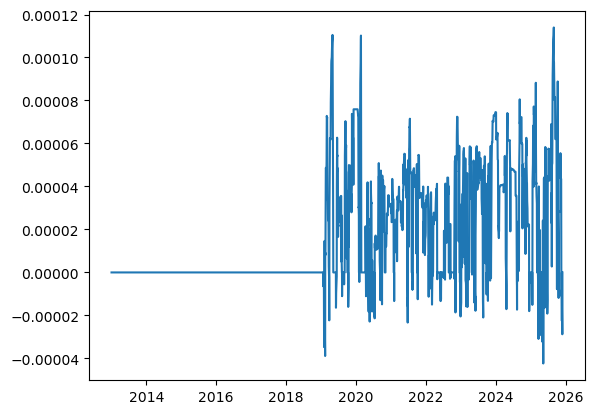

In [118]:
plt.plot(mv_weights.sum(axis=1))
plt.show()

In [105]:
# rets: ログリターン DataFrame (T, N)
rets_arith = np.exp(rets) - 1.0   # 通常リターン

In [106]:
import numpy as np
import pandas as pd

def backtest_buy_and_hold(
    rets_df: pd.DataFrame,
    start_idx: int,
    init_weights: np.ndarray = None,
):
    """
    rets_df: 通常リターン DataFrame (T, N)
    start_idx: ポートフォリオ構築を開始する index（mv_res と揃える）
    init_weights: 初期ウェイト (N,)。None の場合は等ウェイト
    """
    dates = rets_df.index
    assets = rets_df.columns
    n_assets = len(assets)
    n = len(dates)

    if init_weights is None:
        init_weights = np.ones(n_assets) / n_assets

    w = init_weights.copy()
    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)

    for t in range(start_idx, n - 1):
        weights_hist[t, :] = w
        r_next = rets_df.iloc[t + 1].values
        port_ret[t + 1] = float(np.dot(w, r_next))

    weights_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }


In [107]:
import cvxpy as cp

def ewm_cov_matrix(rets_window: pd.DataFrame, halflife: int = 252):
    cov_all = rets_window.ewm(halflife=halflife).cov()
    last_date = rets_window.index[-1]
    cov_last = cov_all.xs(last_date, level=0)
    return cov_last.values  # (N, N)


def backtest_minvar(
    rets_df: pd.DataFrame,
    start_idx: int,
    cov_halflife: int = 252,
    w_lb: float = 0.0,
    w_ub: float = 0.40,
    max_leverage: float = 1.0,
):
    """
    rets_df: 通常リターン DataFrame (T, N)
    start_idx: ポートフォリオ構築開始 index（mv_res と揃える）
    """
    dates = rets_df.index
    assets = rets_df.columns
    n_assets = len(assets)
    n = len(dates)

    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)

    for t in range(start_idx, n - 1):
        # 共分散推定に使う過去データ（シンプルに start_idx から t まで）
        cov_window = rets_df.iloc[: t + 1]
        Sigma = ewm_cov_matrix(cov_window, halflife=cov_halflife)

        w = cp.Variable(n_assets)
        # min (1/2) w' Σ w
        obj = cp.Minimize(0.5 * cp.quad_form(w, Sigma))

        constraints = [
            w >= w_lb,
            w <= w_ub,
            cp.sum(w) <= max_leverage,
        ]

        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.OSQP)

        if w.value is None:
            # 最適化失敗時は等ウェイト
            w_opt = np.ones(n_assets) / n_assets
        else:
            w_opt = np.array(w.value).flatten()

        weights_hist[t, :] = w_opt
        r_next = rets_df.iloc[t + 1].values
        port_ret[t + 1] = float(np.dot(w_opt, r_next))

    weights_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }


In [108]:
mv_res = backtest_mv_jm_xgb(
    rets_df=rets_arith,        # ← 通常リターンを渡す
    asset_results=asset_results,
    start_idx=start_idx_port,
    rf_daily=0.0,
    gamma_risk=10.0,
    gamma_trade=1.0,
    w_lb=0.0,
    w_ub=0.40,
    max_leverage=1.0,
    cov_halflife=252,
    min_bullish=4,
    bear_floor=-0.001,
)
mv_wealth = mv_res["wealth"]


Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optima

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

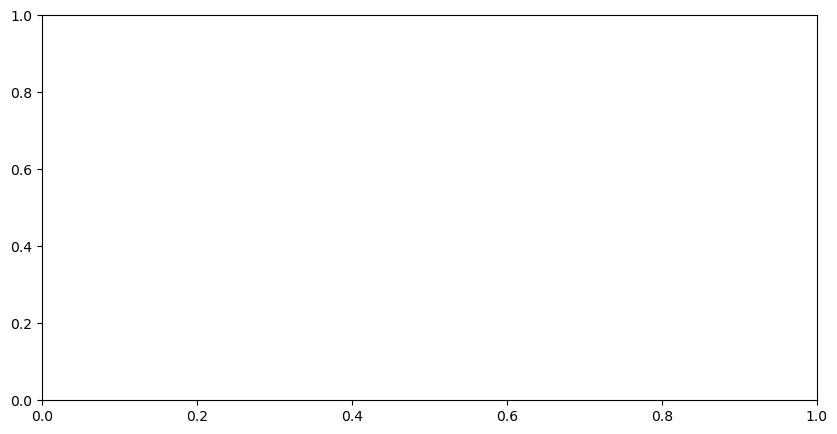

In [109]:
start_idx = start_idx_port  # MV(JM-XGB) で使ったものに合わせる

# 1) Buy & Hold
bh_res = backtest_buy_and_hold(
    rets_df=rets_arith,
    start_idx=start_idx,
    init_weights=None,   # None なら等ウェイト
)

# 2) MinVar
mv_minvar_res = backtest_minvar(
    rets_df=rets_arith,
    start_idx=start_idx,
    cov_halflife=252,
    w_lb=0.0,
    w_ub=0.40,
    max_leverage=1.0,
)

# 3) MV(JM-XGB) は前回までの mv_res を再利用（rets_df を rets_arith に修正しておく）
mv_jm_wealth = mv_res["wealth"]

# 各 wealth を同じ期間に揃える
common_index = mv_jm_wealth.index[start_idx:]
bh_wealth = bh_res["wealth"].loc[common_index]
minvar_wealth = mv_minvar_res["wealth"].loc[common_index]
mv_jm_wealth = mv_jm_wealth.loc[common_index]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(common_index, bh_wealth, label="Buy & Hold (EW)")
plt.plot(common_index, minvar_wealth, label="MinVar")
plt.plot(common_index, mv_jm_wealth, label="MV(JM-XGB)")
plt.legend()
plt.ylabel("Wealth (Initial = 1)")
plt.xlabel("Date")
plt.title("Strategy Comparison: Buy&Hold vs MinVar vs MV(JM-XGB)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
print(type(bh_wealth), bh_wealth.shape)
print(type(minvar_wealth), minvar_wealth.shape)
print(type(mv_jm_wealth), mv_jm_wealth.shape)

<class 'pandas.core.series.Series'> (1745,)
<class 'pandas.core.series.Series'> (1745,)
<class 'pandas.core.series.Series'> (1745,)


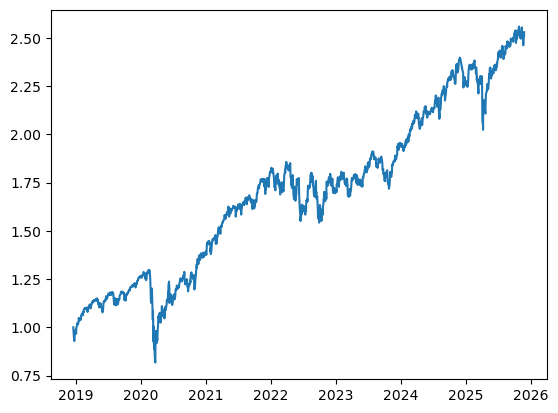

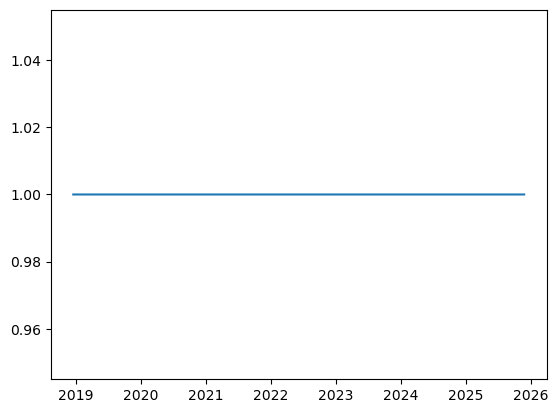

In [113]:
plt.plot(bh_wealth)
plt.show()

plt.plot(minvar_wealth)
plt.show()

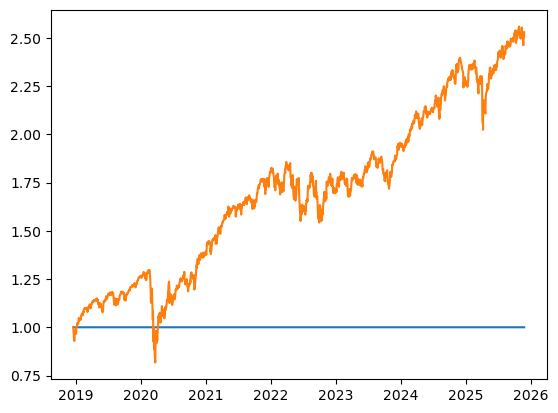

In [115]:
plt.plot(mv_jm_wealth)
plt.plot(bh_wealth)

plt.show()

In [120]:
def select_jump_penalty_on_window(
    rets_window: pd.Series,
    n_regimes: int,
    lambda_grid,
    train_ratio: float = 0.7,
):
    """
    時系列 CV を用いて、その窓の中で 0/1 戦略 Sharpe を最大にする λ を選ぶ簡易版。

    rets_window: 単一資産のログリターン（Series, DateTimeIndex）
    lambda_grid: 候補の jump_penalty の配列（例: [0.0, 0.1, 0.3, 1, 3, 10, 30, 100]）
    """
    n = len(rets_window)
    if n < 100:
        return lambda_grid[0]

    # 特徴量
    X = misc.feature_engineer(rets_window)

    clipper = misc.Clipper(mul=3)
    scaler = misc.Scaler()
    X_clipped = clipper.fit_transform(X)
    X_scaled = scaler.fit_transform(X_clipped)

    split_idx = int(n * train_ratio)
    X_train = X_scaled[:split_idx]
    rets_train = rets_window.iloc[:split_idx]

    X_val_all = X_scaled[split_idx-1:-1]
    rets_val_all = rets_window.iloc[split_idx:]

    if len(rets_val_all) < 10:
        return lambda_grid[0]

    best_lambda = None
    best_sharpe = -np.inf

    for lam in lambda_grid:
        # 1) train 部分で JumpModel をフィット
        jm = misc.JumpModel(n_regimes=n_regimes, jump_penalty=lam)
        jm.fit(X_train)

        labels_train = misc.rearange_labels(jm.labels, rets_train.values)

        # 2) s_{t+1} を教師ラベルにする
        y = labels_train[1:split_idx]
        X_clf = X_scaled[:split_idx-1]

        if len(np.unique(y)) < 2:
            continue

        clf = XGBClassifier()
        clf.fit(X_clf, y.astype(int))

        # 3) validation 部分で 0/1 戦略リターンを計算
        daily_returns = []
        for i in range(len(X_val_all)):
            x_i = X_val_all[i].reshape(1, -1)
            pred_reg_next = clf.predict(x_i)[0]
            r_next = float(rets_val_all.iloc[i])
            if pred_reg_next == 1:   # bull なら risky
                daily_returns.append(r_next)
            else:                    # bear なら cash
                daily_returns.append(0.0)

        daily_returns = np.array(daily_returns)
        if daily_returns.std(ddof=1) == 0:
            sharpe = -np.inf
        else:
            sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std(ddof=1)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_lambda = lam

    if best_lambda is None:
        best_lambda = lambda_grid[0]

    return best_lambda

def run_with_online_lambda_and_mu(
    rets: pd.Series,
    start_idx: int,
    n_regimes: int,
    init_jump_penalty: float,
    fit_freq_days: int,
    lambda_grid=None,
    cv_window_days: int = 252 * 5,
    cv_freq_days: int = 21 * 3,
):
    """
    単一資産のログリターン rets に対して、
    - λ のオンライン更新（TS-CV）
    - JM＋XGB のオンライン学習
    - 各時点の「明日のレジーム予測」とレジーム別平均リターン μ_bull, μ_bear
    を返す。
    """
    if lambda_grid is None:
        lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)

    n = len(rets)
    index = rets.index

    regime_pred = np.full(n, np.nan)
    lambda_path = np.full(n, np.nan)
    mu_bull_path = np.full(n, np.nan)
    mu_bear_path = np.full(n, np.nan)

    current_lambda = init_jump_penalty
    last_cv_date = None
    last_fit_date = None

    model = None
    clf = None
    mu_bull = 0.0
    mu_bear = 0.0

    def should_fit(last_date, current_date, freq_days):
        current = current_date.date()
        if last_date is None:
            return True
        delta = current - last_date
        return delta.days >= freq_days

    # 時間ループ
    for t in range(start_idx, n - 1):
        obs = rets.iloc[: t + 1]
        current_date = obs.index[-1]

        # 1) λ の TS-CV 更新
        if should_fit(last_cv_date, current_date, cv_freq_days) and len(obs) >= cv_window_days:
            window = obs.iloc[-cv_window_days:]
            best_lambda = select_jump_penalty_on_window(
                window,
                n_regimes=n_regimes,
                lambda_grid=lambda_grid,
            )
            current_lambda = best_lambda
            last_cv_date = current_date.date()

            # λ を変えたので次回必ず再フィット
            last_fit_date = None

        # 2) 必要なら JM + XGB を再フィット
        if (last_fit_date is None) or should_fit(last_fit_date, current_date, fit_freq_days):
            last_fit_date = current_date.date()

            X = misc.feature_engineer(obs)
            X_proc = scaler.fit_transform(clipper.fit_transform(X))

            # JM fit
            model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
            model.fit(X_proc)

            labels = misc.rearange_labels(model.labels, obs.values)

            # レジーム別 μ
            if (labels == 1).any():
                mu_bull = obs.values[labels == 1].mean()
            else:
                mu_bull = 0.0
            if (labels == 0).any():
                mu_bear = obs.values[labels == 0].mean()
            else:
                mu_bear = 0.0

            # s_{t+1} を教師ラベルに
            y = pd.Series(labels, index=obs.index).shift(-1)
            train_idx = y.dropna().index

            clf = XGBClassifier()
            clf.fit(
                pd.DataFrame(X_proc, index=obs.index).loc[train_idx],
                y.loc[train_idx].astype(int),
            )
        else:
            X = misc.feature_engineer(obs)
            X_proc = scaler.transform(clipper.transform(X))

        # 3) 「明日のレジーム」を 1ステップ先予測
        x_last = pd.DataFrame(X_proc, index=obs.index).iloc[[-1]]
        pred_reg = clf.predict(x_last)[0]

        regime_pred[t] = pred_reg
        lambda_path[t] = current_lambda
        mu_bull_path[t] = mu_bull
        mu_bear_path[t] = mu_bear

    out = {
        "regime_pred": pd.Series(regime_pred, index=index),
        "lambda": pd.Series(lambda_path, index=index),
        "mu_bull": pd.Series(mu_bull_path, index=index),
        "mu_bear": pd.Series(mu_bear_path, index=index),
    }
    return out

def run_with_online_lambda_and_mu(
    rets: pd.Series,
    start_idx: int,
    n_regimes: int,
    init_jump_penalty: float,
    fit_freq_days: int,
    lambda_grid=None,
    cv_window_days: int = 252 * 5,
    cv_freq_days: int = 21 * 3,
):
    """
    単一資産のログリターン rets に対して、
    - λ のオンライン更新（TS-CV）
    - JM＋XGB のオンライン学習
    - 各時点の「明日のレジーム予測」とレジーム別平均リターン μ_bull, μ_bear
    を返す。
    """
    if lambda_grid is None:
        lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)

    n = len(rets)
    index = rets.index

    regime_pred = np.full(n, np.nan)
    lambda_path = np.full(n, np.nan)
    mu_bull_path = np.full(n, np.nan)
    mu_bear_path = np.full(n, np.nan)

    current_lambda = init_jump_penalty
    last_cv_date = None
    last_fit_date = None

    model = None
    clf = None
    mu_bull = 0.0
    mu_bear = 0.0

    def should_fit(last_date, current_date, freq_days):
        current = current_date.date()
        if last_date is None:
            return True
        delta = current - last_date
        return delta.days >= freq_days

    # 時間ループ
    for t in range(start_idx, n - 1):
        obs = rets.iloc[: t + 1]
        current_date = obs.index[-1]

        # 1) λ の TS-CV 更新
        if should_fit(last_cv_date, current_date, cv_freq_days) and len(obs) >= cv_window_days:
            window = obs.iloc[-cv_window_days:]
            best_lambda = select_jump_penalty_on_window(
                window,
                n_regimes=n_regimes,
                lambda_grid=lambda_grid,
            )
            current_lambda = best_lambda
            last_cv_date = current_date.date()

            # λ を変えたので次回必ず再フィット
            last_fit_date = None

        # 2) 必要なら JM + XGB を再フィット
        if (last_fit_date is None) or should_fit(last_fit_date, current_date, fit_freq_days):
            last_fit_date = current_date.date()

            X = misc.feature_engineer(obs)
            X_proc = scaler.fit_transform(clipper.fit_transform(X))

            # JM fit
            model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
            model.fit(X_proc)

            labels = misc.rearange_labels(model.labels, obs.values)

            # レジーム別 μ
            if (labels == 1).any():
                mu_bull = obs.values[labels == 1].mean()
            else:
                mu_bull = 0.0
            if (labels == 0).any():
                mu_bear = obs.values[labels == 0].mean()
            else:
                mu_bear = 0.0

            # s_{t+1} を教師ラベルに
            y = pd.Series(labels, index=obs.index).shift(-1)
            train_idx = y.dropna().index

            clf = XGBClassifier()
            clf.fit(
                pd.DataFrame(X_proc, index=obs.index).loc[train_idx],
                y.loc[train_idx].astype(int),
            )
        else:
            X = misc.feature_engineer(obs)
            X_proc = scaler.transform(clipper.transform(X))

        # 3) 「明日のレジーム」を 1ステップ先予測
        x_last = pd.DataFrame(X_proc, index=obs.index).iloc[[-1]]
        pred_reg = clf.predict(x_last)[0]

        regime_pred[t] = pred_reg
        lambda_path[t] = current_lambda
        mu_bull_path[t] = mu_bull
        mu_bear_path[t] = mu_bear

    out = {
        "regime_pred": pd.Series(regime_pred, index=index),
        "lambda": pd.Series(lambda_path, index=index),
        "mu_bull": pd.Series(mu_bull_path, index=index),
        "mu_bear": pd.Series(mu_bear_path, index=index),
    }
    return out

def ewm_cov_matrix(rets_window: pd.DataFrame, halflife: int = 252):
    """
    過去リターンから EWM 共分散を推定し、最後の時点の共分散行列を返す。
    rets_window: 通常リターン DataFrame (T, N)
    """
    cov_all = rets_window.ewm(halflife=halflife).cov()
    last_date = rets_window.index[-1]
    cov_last = cov_all.xs(last_date, level=0)
    return cov_last.values  # (N, N)

def backtest_mv_jm_xgb(
    rets_df: pd.DataFrame,     # 通常リターン (T, N)
    asset_results: dict,       # 各資産の run_with_online_lambda_and_mu 結果
    start_idx: int,
    rf_daily: float = 0.0,
    gamma_risk: float = 10.0,
    gamma_trade: float = 1.0,
    w_lb: float = 0.0,
    w_ub: float = 0.40,
    cov_halflife: int = 252,
    bear_floor: float = -0.001,   # bear μ の下限（-10bps）など
):
    """
    MV(JM-XGB) ポートフォリオをバックテストする。

    ルール:
    - 各資産ごとに「明日のレジーム予測」とレジーム別 μ_bull, μ_bear を用意
    - reg=1 (bull) → μ_bull, reg=0 (bear) → max(μ_bear, bear_floor)
    - bull 資産が 1つ以上ある場合:
        ・bear の w_j=0
        ・bull 資産だけで Σ w_j = 1（現金 0）
    - bull が 0（全て bear）の場合:
        ・全 risky 資産 w_j=0（現金 100%）
    """
    dates = rets_df.index
    assets = list(rets_df.columns)
    n_assets = len(assets)
    n = len(dates)

    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)
    lambda_hist = np.zeros((n, n_assets))

    w_prev = np.zeros(n_assets)

    for t in range(start_idx, n - 1):
        date_t = dates[t]

        # 1) μ ベクトルと bull/bear 情報を作る
        mu_vec = np.zeros(n_assets)
        bullish_mask = np.zeros(n_assets, dtype=bool)

        for j, asset in enumerate(assets):
            res = asset_results[asset]
            reg = res["regime_pred"].loc[date_t]
            mu_bull = res["mu_bull"].loc[date_t]
            mu_bear = res["mu_bear"].loc[date_t]
            lam = res["lambda"].loc[date_t]

            if reg == 1:
                mu_j = mu_bull
                bullish_mask[j] = True
            else:
                mu_j = max(mu_bear, bear_floor)

            mu_vec[j] = mu_j
            lambda_hist[t, j] = lam

        n_bull = bullish_mask.sum()

        if n_bull == 0:
            # 全 bear → risky 0, 現金 100%
            w_opt = np.zeros(n_assets)
        else:
            # bull ≥ 1 → bull 資産だけで Σw=1
            cov_window = rets_df.iloc[: t + 1]
            Sigma = ewm_cov_matrix(cov_window, halflife=cov_halflife)

            w = cp.Variable(n_assets)

            risk_term  = 0.5 * gamma_risk * cp.quad_form(w, Sigma)
            ret_term   = - mu_vec @ w
            trade_term = gamma_trade * cp.norm1(w - w_prev)
            obj = cp.Minimize(risk_term + ret_term + trade_term)

            constraints = [
                w >= w_lb,
                w <= w_ub,
            ]

            # bear 資産は w=0
            for j in range(n_assets):
                if not bullish_mask[j]:
                    constraints.append(w[j] == 0.0)

            # bull 資産だけで合計 1
            constraints.append(cp.sum(w[bullish_mask]) == 1.0)

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.OSQP)

            if w.value is None:
                # 解けない場合は bull 資産に等分配
                w_opt = np.zeros(n_assets)
                w_opt[bullish_mask] = 1.0 / n_bull
            else:
                w_opt = np.array(w.value).flatten()

        # 3) リターンと wealth 更新
        weights_hist[t, :] = w_opt
        r_next_vec = rets_df.iloc[t + 1].values

        risky_ret = np.dot(w_opt, r_next_vec)
        rf_weight = max(0.0, 1.0 - w_opt.sum())   # bull>=1 の日は 0, all-bearの日は1
        total_ret = risky_ret + rf_weight * rf_daily

        port_ret[t + 1] = total_ret
        w_prev = w_opt

    weights_hist_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    lambda_hist_df = pd.DataFrame(lambda_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_hist_df,
        "lambda": lambda_hist_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }

def backtest_buy_and_hold(
    rets_df: pd.DataFrame,
    start_idx: int,
    init_weights: np.ndarray = None,
):
    dates = rets_df.index
    assets = rets_df.columns
    n_assets = len(assets)
    n = len(dates)

    if init_weights is None:
        init_weights = np.ones(n_assets) / n_assets

    w = init_weights.copy()
    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)

    for t in range(start_idx, n - 1):
        weights_hist[t, :] = w
        r_next = rets_df.iloc[t + 1].values
        port_ret[t + 1] = float(np.dot(w, r_next))

    weights_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }


def backtest_minvar(
    rets_df: pd.DataFrame,
    start_idx: int,
    cov_halflife: int = 252,
    w_lb: float = 0.0,
    w_ub: float = 0.40,
):
    dates = rets_df.index
    assets = rets_df.columns
    n_assets = len(assets)
    n = len(dates)

    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)

    for t in range(start_idx, n - 1):
        cov_window = rets_df.iloc[: t + 1]
        Sigma = ewm_cov_matrix(cov_window, halflife=cov_halflife)

        w = cp.Variable(n_assets)
        obj = cp.Minimize(0.5 * cp.quad_form(w, Sigma))

        constraints = [
            w >= w_lb,
            w <= w_ub,
            cp.sum(w) == 1.0,   # 常に risky 資産で 100%
        ]

        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.OSQP)

        if w.value is None:
            w_opt = np.ones(n_assets) / n_assets
        else:
            w_opt = np.array(w.value).flatten()

        weights_hist[t, :] = w_opt
        r_next = rets_df.iloc[t + 1].values
        port_ret[t + 1] = float(np.dot(w_opt, r_next))

    weights_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }



[*********************100%***********************]  9 of 9 completed
100%|██████████| 9/9 [36:15<00:00, 241.68s/it]


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

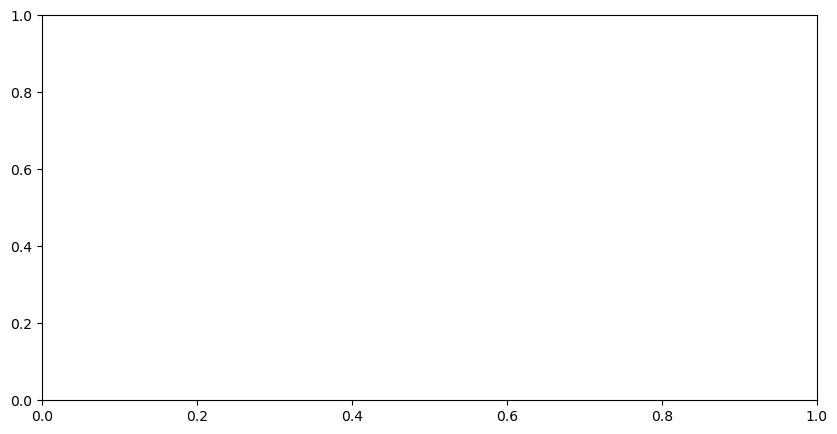

In [121]:
# 1) データ取得
start_date = "2013-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

ticker = [
    "XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"
]
df = yf.download(ticker, start=start_date, end=end_date)["Close"]

# ログリターン（JM / 特徴量用）
rets_log = np.log(df).diff().dropna()
# 通常リターン（ポートフォリオ計算用）
rets_arith = np.exp(rets_log) - 1.0

assets = rets_log.columns

# 2) 各資産について JM-XGB (オンライン λ 更新＋μ 推定)
start_idx_jm = 1000
n_regimes = 2
init_jump_penalty = 100.0
fit_freq_days = 7 * 4

lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

asset_results = {}
for asset in tqdm(assets):
    res = run_with_online_lambda_and_mu(
        rets=rets_log[asset],
        start_idx=start_idx_jm,
        n_regimes=n_regimes,
        init_jump_penalty=init_jump_penalty,
        fit_freq_days=fit_freq_days,
        lambda_grid=lambda_grid,
        cv_window_days=252*5,
        cv_freq_days=21*3,
    )
    asset_results[asset] = res

# 3) MV(JM-XGB) ポートフォリオ
start_idx_port = 1500   # 学習・CV の分だけ余裕を持たせる
mv_res = backtest_mv_jm_xgb(
    rets_df=rets_arith,
    asset_results=asset_results,
    start_idx=start_idx_port,
    rf_daily=0.0,
    gamma_risk=10.0,
    gamma_trade=1.0,
    w_lb=0.0,
    w_ub=0.40,
    cov_halflife=252,
    bear_floor=-0.001,
)
mv_wealth = mv_res["wealth"]

# 4) Buy&Hold / MinVar
bh_res = backtest_buy_and_hold(
    rets_df=rets_arith,
    start_idx=start_idx_port,
    init_weights=None,   # 等ウェイト
)
minvar_res = backtest_minvar(
    rets_df=rets_arith,
    start_idx=start_idx_port,
    cov_halflife=252,
    w_lb=0.0,
    w_ub=0.40,
)

# 5) 共通インデックスで比較
common_index = mv_wealth.index[start_idx_port:]
bh_wealth = bh_res["wealth"].loc[common_index].squeeze()
minvar_wealth = minvar_res["wealth"].loc[common_index].squeeze()
mv_wealth = mv_wealth.loc[common_index].squeeze()

plt.figure(figsize=(10, 5))
plt.plot(common_index, bh_wealth.values,     label="Buy & Hold (EW)")
plt.plot(common_index, minvar_wealth.values, label="MinVar")
plt.plot(common_index, mv_wealth.values,     label="MV(JM-XGB)")
plt.legend()
plt.ylabel("Wealth (Initial = 1)")
plt.xlabel("Date")
plt.title("Strategy Comparison: Buy&Hold vs MinVar vs MV(JM-XGB)")
plt.grid(True)
plt.tight_layout()
plt.show()


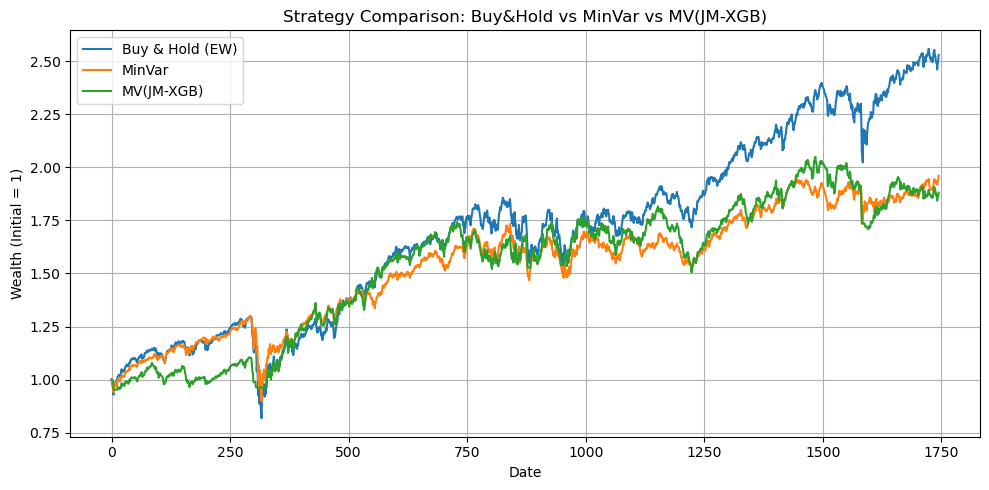

In [122]:
plt.figure(figsize=(10, 5))
plt.plot(bh_wealth.values,     label="Buy & Hold (EW)")
plt.plot(minvar_wealth.values, label="MinVar")
plt.plot(mv_wealth.values,     label="MV(JM-XGB)")
plt.legend()
plt.ylabel("Wealth (Initial = 1)")
plt.xlabel("Date")
plt.title("Strategy Comparison: Buy&Hold vs MinVar vs MV(JM-XGB)")
plt.grid(True)
plt.tight_layout()
plt.show()